In [2]:
import awkward as ak
import numpy as np
import hist as hs
from coffea import processor
from coffea.nanoevents.methods import vector, candidate

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt

In [3]:
class LLP_ntuple_processor(processor.ProcessorABC):
    """
    This class is used to process the ntuples created by the LLP ntuple producer.
    """
    def process(self, events):
        """
        This function is used to process the ntuples into histograms.
        :param events:
        :return:
        """

        # create a dictionary for storing dimensions of different parts of the detector
        detector_dimensions = {
            'csc': {},
            'dt': {},
            'cms': {},
        }

        # fill detector_dimensions with the dimensions of the different parts of the detector
        s = 1e2  # scale factor
        detector_dimensions['csc']['zmin'] = s * 5.5
        detector_dimensions['csc']['zmax'] = s * 10.
        detector_dimensions['csc']['rmin'] = s * 0.
        detector_dimensions['csc']['rmax'] = s * 7.
        detector_dimensions['dt']['zmin'] = s * 0.
        detector_dimensions['dt']['zmax'] = s * 6.5
        detector_dimensions['dt']['rmin'] = s * 4.
        detector_dimensions['dt']['rmax'] = s * 7.5

        detector_dimensions['cms']['zmin'] = s * 0.
        detector_dimensions['cms']['zmax'] = s * 12.
        detector_dimensions['cms']['rmin'] = s * 0.
        detector_dimensions['cms']['rmax'] = s * 8.

        dataset = events.metadata['dataset']
        sumw = ak.sum(events.genWeight)

        out = {
            dataset: {
                "entries": len(events),
                "sumw": sumw,
            }
        }

        def R(x, y):
            """
            computes radius
            :param x:
            :param y:
            :return:
            """
            return np.sqrt(x ** 2 + y ** 2)

        # simple if statement that assigns a variable 'pid' to 9900015 or 1000023 if any of the events has one of
        # those particles
        if ak.any(events.gParticleId == 9900015): pid = 9900015
        if ak.any(events.gParticleId == 1000023): pid = 1000023

        # we need the decay vertices of the llps but events doesn't have that information. but we do have access to
        # the id of the mother particles (gParticleMotherId) as well as production vertices of all particles (
        # gParticleProdVertexX, gParticleProdVertexY, gParticleProdVertexZ) Make a mask of the particles whose mother
        # is the llp
        mother_llp_mask = events.gParticleMotherId == pid
        # However, each llp will have multiple products, so events.gParticleProdVertexX[mother_llp_mask] will have
        # duplicates To remove the duplicates we can use a trick that uses ak.argmax to find the index of the first
        # occurrence of each truth value Make an awkward array of the indices of the first occurrence of each truth
        # value within the second level of the mask
        llp_daughter_index = ak.argmax(mother_llp_mask, axis=1, keepdims=True)
        # Now we can use llp_daughter_index to get the indexes of the llps themselves using gParticleMotherIndex
        llp_index = events.gParticleMotherIndex[llp_daughter_index]

        # make a zip of the llp decay vertices and PtEtaPhiMLorentzVector
        cms_llps = ak.zip(
            {
                'X': events.gParticleProdVertexX[llp_daughter_index],
                'Y': events.gParticleProdVertexY[llp_daughter_index],
                'Z': events.gParticleProdVertexZ[llp_daughter_index],
                'R': R(events.gParticleProdVertexX[llp_daughter_index],
                       events.gParticleProdVertexY[llp_daughter_index]),
                'pt': events.gParticlePt[llp_index],
                'phi': events.gParticlePhi[llp_index],
                'eta': events.gParticleEta[llp_index],
                'mass': ak.ones_like(events.gParticlePt[llp_index]),
                'E': events.gParticleE[llp_index],
            },
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
        )

        # do the same with cscRechitCluster
        csc_cls = ak.zip(
            {
                'X': events.cscRechitClusterX,
                'Y': events.cscRechitClusterY,
                'Z': events.cscRechitClusterZ,
                'R': R(events.cscRechitClusterX, events.cscRechitClusterY),
                'pt': ak.ones_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'mass': ak.ones_like(events.cscRechitClusterPhi),
                'E': ak.ones_like(events.cscRechitClusterPhi),
            },
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
        )

        # do exactly the same with dtRechitCluster
        dt_cls = ak.zip(
            {
                'X': events.dtRechitClusterX,
                'Y': events.dtRechitClusterY,
                'Z': events.dtRechitClusterZ,
                'R': R(events.dtRechitClusterX, events.dtRechitClusterY),
                'pt': ak.ones_like(events.dtRechitClusterPhi),
                'phi': events.dtRechitClusterPhi,
                'eta': events.dtRechitClusterEta,
                'mass': ak.ones_like(events.dtRechitClusterPhi),
                'E': ak.ones_like(events.dtRechitClusterPhi),
            },
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
        )

        # do exactly the same with cscRechits
        csc_rechits = ak.zip(
            {
                'X': events.cscRechitsX,
                'Y': events.cscRechitsY,
                'Z': events.cscRechitsZ,
                'R': R(events.cscRechitsX, events.cscRechitsY),
                'pt': ak.ones_like(events.cscRechitsPhi),
                'phi': events.cscRechitsPhi,
                'eta': events.cscRechitsEta,
                'mass': ak.ones_like(events.cscRechitsPhi),
                'E': ak.ones_like(events.cscRechitsPhi),
            },
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
        )

        # do exactly the same with dtRechits
        dt_rechits = ak.zip(
            {
                'X': events.dtRechitX,
                'Y': events.dtRechitY,
                'Z': events.dtRechitZ,
                'R': R(events.dtRechitX, events.dtRechitY),
                'pt': ak.ones_like(events.dtRechitPhi),
                'phi': events.dtRechitPhi,
                'eta': events.dtRechitEta,
                'mass': ak.ones_like(events.dtRechitPhi),
                'E': ak.ones_like(events.dtRechitPhi),
            },
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
        )

        def csc_cut(v):
            """
            takes a PtEtaPhiMLorentzVector and returns a PtEtaPhiMLorentzVector with cuts in the csc region
            :param v:
            :return:
            """
            dims = detector_dimensions['csc']
            cut = (
                    (abs(v.eta) < 2.4) &
                    (abs(v.Z) > dims['zmin']) & (abs(v.Z) < dims['zmax']) &
                    (v.R < dims['rmax'])
            )
            return v[cut]

        def dt_cut(v):
            """
            takes a PtEtaPhiMLorentzVector and returns a PtEtaPhiMLorentzVector with cuts in the dt region
            :param v:
            :return:
            """
            cut = (
                    (v.R > detector_dimensions['dt']['rmin']) & (v.R < detector_dimensions['dt']['rmax']) &
                    (abs(v.Z) < detector_dimensions['dt']['zmax'])
            )
            return v[cut]

        def cartesian_delta_r(v1, v2):
            """
            takes two PtEtaPhiMLorentzVector awkward arrays and returns all the combinations of
            pairs and deltaR's
            :param v1:
            :param v2:
            :return:
            """
            # ensure that the key and the name of the variable are the same for consistency
            # this is probably bad practice, but it works
            v1name = [k for k, v in locals().items() if v is v1][0]
            v2name = [k for k, v in locals().items() if v is v2][0]
            pairs = ak.cartesian({v1name: v1, v2name: v2}, axis=1, nested=True)
            delta_r = pairs.v1.delta_r(pairs.v2)
            return ak.zip(
                {
                    'delta_r': delta_r,
                    v1name: pairs.v1,
                    v2name: pairs.v2,
                },
            )

        def delta_r_cut(v, threshold):
            """
            takes pairs and returns pairs with delta_r < threshold
            :param v:
            :param threshold:
            :return:
            """
            cut = v.delta_r < threshold
            return v[cut]

        def init_2d_hist(bins):
            """
            takes a number of bins and returns a 2D histogram with those bins within the cms region
            :param bins:
            :return:
            """
            dims = detector_dimensions['cms']
            return (
                hs.Hist.new
                    .Reg(bins, dims['zmin'], dims['zmax'], name='z', label='z [cm]')
                    .Reg(bins, dims['rmin'], dims['rmax'], name='r', label='r [cm]')
                    .Double()
            )

        def fill_2d_hist(hist, v):
            """
            takes a 2D histogram and a PtEtaPhiMLorentzVector and fills it
            :param hist:
            :param v:
            :return:
            """
            z = abs(ak.flatten(v.Z, axis=None))
            r = abs(ak.flatten(v.R, axis=None))
            hist.fill(z=z, r=r)

        def init_fill_2d_hist(bins, v):
            """
            takes a number of bins and a PtEtaPhiMLorentzVector, then initializes and fills a 2D histogram with those bins
            :param bins:
            :param v:
            :return:
            """
            hist = init_2d_hist(bins)
            fill_2d_hist(hist, v)
            return hist

        def init_1d_hist(bins, domain, name, label):
            """
            takes a number of bins, a domain, a name, and a label and returns a 1D histogram with those bins
            :param bins:
            :param domain:
            :param name:
            :param label:
            :return:
            """
            return hs.Hist.new.Reg(bins, domain[0], domain[1], name=name, label=label).Double()

        def fill_1d_hist(hist, arr):
            """
            takes a 1D histogram and a flat array and fills it
            :param hist:
            :param arr:
            :return:
            """
            hist.fill(ak.flatten(arr, axis=None))

        def init_fill_1d_hist(bins, domain, arr, name, label):
            """
            takes a number of bins, a domain, a flat array, a name, and a label and initializes and fills a 1D
            histogram with those bins
            :param bins:
            :param domain:
            :param arr:
            :param name:
            :param label:
            :return:
            """
            hist = init_1d_hist(bins, domain, name, label)
            fill_1d_hist(hist, arr)
            return hist

        # naming convention is as follows:
        # <region of>_<cluster or rechit>_<region of>_llps_pairs
        # cut cms_llps to detector regions
        csc_llps = csc_cut(cms_llps)
        dt_llps = dt_cut(cms_llps)

        # delta r pairs between cls and cms_llps
        csc_cls_cms_llp_pairs = cartesian_delta_r(csc_cls, cms_llps)
        dt_cls_cms_llp_pairs = cartesian_delta_r(dt_cls, cms_llps)

        # delta r's between cls and llps in region
        csc_cls_csc_llps_pairs = cartesian_delta_r(csc_cls, csc_llps)
        dt_cls_dt_llps_pairs = cartesian_delta_r(dt_cls, dt_llps)

        # delta r's between rechits and cms_llps
        csc_rechits_cms_llp_pairs = cartesian_delta_r(csc_rechits, cms_llps)
        dt_rechits_cms_llp_pairs = cartesian_delta_r(dt_rechits, cms_llps)

        # delta r's between rechits and llps in region
        csc_rechits_csc_llps_pairs = cartesian_delta_r(csc_rechits, csc_llps)
        dt_rechits_dt_llps_pairs = cartesian_delta_r(dt_rechits, dt_llps)

        # same as before but with delta_r < threshold
        # naming convention is as follows:
        # <region of>_<cluster or rechit>_<region of>_llps_pairs_dr_cut
        threshold = 0.4
        csc_cls_cms_llp_pairs_dr_cut = delta_r_cut(csc_cls_cms_llp_pairs, threshold)
        dt_cls_cms_llp_pairs_dr_cut = delta_r_cut(dt_cls_cms_llp_pairs, threshold)
        csc_cls_csc_llps_pairs_dr_cut = delta_r_cut(csc_cls_csc_llps_pairs, threshold)
        dt_cls_dt_llps_pairs_dr_cut = delta_r_cut(dt_cls_dt_llps_pairs, threshold)
        csc_rechits_cms_llp_pairs_dr_cut = delta_r_cut(csc_rechits_cms_llp_pairs, threshold)
        dt_rechits_cms_llp_pairs_dr_cut = delta_r_cut(dt_rechits_cms_llp_pairs, threshold)
        csc_rechits_csc_llps_pairs_dr_cut = delta_r_cut(csc_rechits_csc_llps_pairs, threshold)
        dt_rechits_dt_llps_pairs_dr_cut = delta_r_cut(dt_rechits_dt_llps_pairs, threshold)

        bins = 60
        hists1d = {
            'cms_llps':{}, 'csc_llps':{}, 'dt_llps':{},
            'csc_cls':{}, 'dt_cls':{},
        }

        hists2d = {
            'cms_llps':{}, 'csc_llps':{}, 'dt_llps':{},
            'csc_cls':{}, 'dt_cls':{},
        }

        # fill 2d histograms    
        hists2d['cms_llps'] = init_fill_2d_hist(bins, cms_llps)
        hists2d['csc_cls'] = init_fill_2d_hist(bins, csc_cls)


        out[dataset]['hists1d'] = hists1d
        out[dataset]['hists2d'] = hists2d

        return out

    def postprocess(self, accumulator):
        return accumulator

In [4]:

# digging up
def rootAdds(directory):
    my_file = open(directory, "r")
    data = my_file.read().strip()
    data_into_list = data.split("\n")
    my_file.close()
    return data_into_list

fileset = {}
fileset['hnl'] = rootAdds('notebooks/Bplus/rootAdds/BToHNL_MuonAndHNLGenFilter_mHNL1p0_ctau1000.txt')
#fileset['phi'] = rootAdds('notebooks/Bplus/rootAdds/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000.txt')

out = processor.run_uproot_job(
    fileset,
    treename="ntuples/llp",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 6},
    maxchunks=30,
)

Preprocessing:   0%|          | 0/599 [00:00<?, ?file/s]

Processing:   0%|          | 0/30 [00:00<?, ?chunk/s]

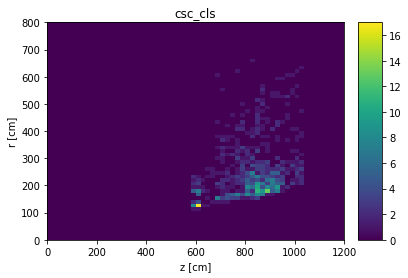

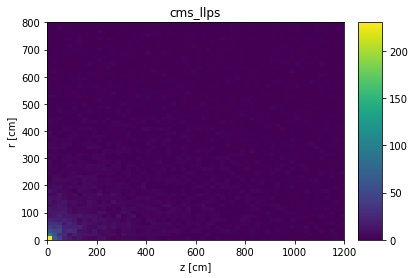

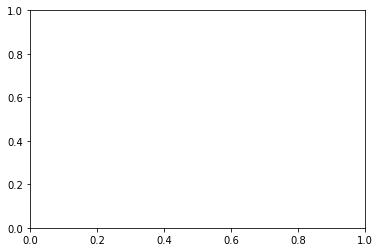

In [5]:
for region in out['hnl']['hists2d']:
    try:
        hep.hist2dplot(out['hnl']['hists2d'][region])
        plt.title(f'{region}')
        plt.show()
    except:
        pass